# Backpropagation and Multilayer Neural Networks

### Goals: 
- Intro: train a neural network with high level framework `Keras`
- Diving deep: implement a real gradient descent in `Numpy`
- Auto-differentiation: the basics of `TensorFlow`

### Dataset:
- Digits: 10 class handwritten digits
- http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html#sklearn.datasets.load_digits

In [2]:
%matplotlib inline 
# display figures in the notebook
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits

digits = load_digits()

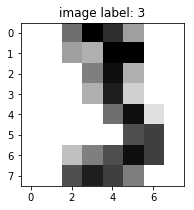

In [3]:
sample_index = 45
plt.figure(figsize=(3, 3))
plt.imshow(digits.images[sample_index], cmap=plt.cm.gray_r,
           interpolation='nearest')
plt.title("image label: %d" % digits.target[sample_index]);

### Preprocessing

- normalization
- train/test split

In [4]:
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split

data = np.asarray(digits.data, dtype='float32')
target = np.asarray(digits.target, dtype='int32')

X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=0.15, random_state=37)
print(data)
print(target)
# mean = 0 ; standard deviation = 1.0
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# print(scaler.mean_)
# print(scaler.scale_)

[[  0.   0.   5. ...,   0.   0.   0.]
 [  0.   0.   0. ...,  10.   0.   0.]
 [  0.   0.   0. ...,  16.   9.   0.]
 ..., 
 [  0.   0.   1. ...,   6.   0.   0.]
 [  0.   0.   2. ...,  12.   0.   0.]
 [  0.   0.  10. ...,  12.   1.   0.]]
[0 1 2 ..., 8 9 8]


Let's display the one of the transformed sample (after feature standardization):

In [ ]:
sample_index = 45
plt.figure(figsize=(3, 3))
plt.imshow(X_train[sample_index].reshape(8, 8),
           cmap=plt.cm.gray_r, interpolation='nearest')
plt.title("transformed sample\n(standardization)");

The scaler objects makes it possible to recover the original sample:

In [ ]:
plt.figure(figsize=(3, 3))
plt.imshow(scaler.inverse_transform(X_train[sample_index]).reshape(8, 8),
           cmap=plt.cm.gray_r, interpolation='nearest')
plt.title("original sample");

In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

# I) Feed Forward NN with Keras

Objectives of this section:

- Build and train a first feedforward network using `Keras`
    - https://keras.io/getting-started/sequential-model-guide/
- Experiment with different optimizers, activations, size of layers, initializations

### a) Keras Workflow

To build a first neural network we need to turn the target variable into a vector "one-hot-encoding" representation. Here are the labels of the first samples in the training set encoded as integers:

In [ ]:
y_train[:3]

Keras provides a utility function to convert integer-encoded categorical variables as one-hot encoded values:

In [ ]:
from tensorflow.contrib import keras
from keras.utils.np_utils import to_categorical

Y_train = to_categorical(y_train)
Y_train[:3]

We can now build an train a our first feed forward neural network using the high level API from keras:

- first we define the model by stacking layers with the right dimensions
- then we define a loss function and plug the SGD optimizer
- then we feed the model the training data for fixed number of epochs

In [ ]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras import optimizers

N = X_train.shape[1]
H = 100
K = 10

model = Sequential()
model.add(Dense(H, input_dim=N))
model.add(Activation("tanh"))
model.add(Dense(K))
model.add(Activation("softmax"))

model.compile(optimizer=optimizers.SGD(lr=0.1),
              loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, Y_train, nb_epoch=15, batch_size=32);

### b) Exercises: Impact of the Optimizer

- Try to decrease the learning rate value by 10 or 100. What do you observe?

- Try to increase the learning rate value to make the optimization diverge.

- Configure the SGD optimizer to enable a Nesterov momentum of 0.9
  
Note that the keras API documentation is avaiable at:

https://keras.io/

It is also possible to learn more about the parameters of a class by using the question mark: type and evaluate:

```python
optimizers.SGD?
```

in a jupyter notebook cell.

In [ ]:
# %load solutions/keras_sgd_and_momentum.py

- Replace the SGD optimizer by the Adam optimizer from keras and run it
  with the default parameters.

- Add another hidden layer and use the "Rectified Linear Unit" for each
  hidden layer. Can you still train the model with Adam with its default global
  learning rate?

- Bonus: try the Adadelta optimizer (no learning rate to set).

Hint: use `optimizers.<TAB>` to tab-complete the list of implemented optimizers in Keras.

In [ ]:
# %load solutions/keras_adam_and_adadelta.py

### c) Exercises: forward pass and generalization

- Compute predictions on test set using `model.predict_classes(...)`
- Compute average accuracy of the model on the test set

In [ ]:
# %load solutions/keras_accuracy_on_test_set.py

- Compute the conditional probabilities of sample number 42 of the test set with `model.predict_proba(...)`
- Derive the loss (negative log likelihood of that sample) using numpy operations
- Compute the average negative log likelihood of the test set.
- Compare this value to the training loss reported by keras: is the model overfitting or underfitting?

Note: you might need to retrain the model with a larger number of epochs (e.g. 50) to ensure that it has fully converged.

In [ ]:
# %load solutions/keras_loss_on_test_set.py

## d) Home assignment: impact of initialization

Let us now study the impact of a bad initialization when training
a deep feed forward network.

By default Keras dense layers use the "Glorot Uniform" initialization
strategy to initialize the weight matrices:

- each weight coefficient is randomly sampled from [-scale, scale]
- scale is proportional to $\frac{1}{\sqrt{n_{in} + n_{out}}}$

This strategy is known to work well to initialize deep neural networks
with "tanh" or "relu" activation functions and then trained with
standard SGD.

To assess the impact of initialization let us plug an alternative init
scheme into a 2 hidden layers networks with "tanh" activations.
For the sake of the example let's use normal distributed weights
with a manually adjustable scale (standard deviation) and see the
impact the scale value:

In [ ]:
from keras import initializers

normal_init = initializers.RandomNormal(stddev=0.01)

model = Sequential()
model.add(Dense(H, input_dim=N, kernel_initializer=normal_init))
model.add(Activation("tanh"))
model.add(Dense(K, kernel_initializer=normal_init))
model.add(Activation("tanh"))
model.add(Dense(K, kernel_initializer=normal_init))
model.add(Activation("softmax"))

model.compile(optimizer=optimizers.SGD(lr=0.1),
              loss='categorical_crossentropy')

history = model.fit(X_train, Y_train,
                    epochs=10, batch_size=32)

#### Questions:

- Try the following initialization schemes and see whether
  the SGD algorithm can successfully train the network or
  not:
  
  - a very small e.g. `scale=1e-3`
  - a larger scale e.g. `scale=1` or `10`
  - initialize all weights to 0 (constant initialization)
  
- What do you observe? Can you find an explanation for those
  outcomes?

- Are better solvers such as SGD with momentum or Adam able
  to deal better with such bad initializations?

In [ ]:
# %load solutions/keras_initializations.py
large_scale_init = initializers.RandomNormal(stddev=1)
small_scale_init = initializers.RandomNormal(stddev=1e-3)


optimizer_list = [
    ('SGD', optimizers.SGD(lr=0.1)),
    ('Adam', optimizers.Adam()),
#     ('SGD + Nesterov momentum', optimizers.SGD(
#             lr=0.1, momentum=0.9,nesterov=True)),
]

init_list = [
    ('glorot uniform init', 'glorot_uniform', '-'),
    ('small init scale', small_scale_init, '-'),
    ('large init scale', large_scale_init, '-'),
    ('zero init', 'zero', '--'),
]


for optimizer_name, optimizer in optimizer_list:
    plt.figure(figsize=(12, 6))
    for init_name, init, linestyle in init_list:
        model = Sequential()
        model.add(Dense(H, input_dim=N, kernel_initializer=init))
        model.add(Activation("tanh"))
        model.add(Dense(K, kernel_initializer=init))
        model.add(Activation("tanh"))
        model.add(Dense(K, kernel_initializer=init))
        model.add(Activation("softmax"))

        model.compile(optimizer=optimizer,
                      loss='categorical_crossentropy')

        history = model.fit(X_train, Y_train,
                            epochs=10, batch_size=32, verbose=0)
        plt.plot(history.history['loss'], linestyle=linestyle,
                 label=init_name)

    plt.xlabel('# epochs')
    plt.ylabel('Training loss')
    plt.ylim(0, 6)
    plt.legend(loc='best');
    plt.title('Impact of initialization on convergence with %s'
              % optimizer_name)

In [ ]:
# %load solutions/keras_initializations_analysis.py
# Analysis
#
# If the network is initialized to zero weights, the activations of the hidden
# layers are always set to zero, whatever the value of the inputs. The gradient
# is always zero for all training samples and no learning can happen with any
# gradient-based optimizer (SGD, Adam...): the loss stays constant.
#
# A network with null weights has null gradients but this not a local minimum
# (nor a local maximum): it is a saddle point at the center of a neighborhood
# with very low gradients. 
#
# Therefore when the scale of a random initializations of the weights is too
# small, SGD has a hard time evading that area of low gradients. Adding
# momentum can help but especially for deep networks it can take many epochs to
# evade the area.
#
# Initializing the weights with large random values will make the output
# distribution (softmax) very peaky: the network is very "confident" of its
# predictions even if they are completely random. This leads to a very high
# initial loss value.
#
# The softmax function does not saturate (bad classification always have a
# non-zero gradient). However the intermediate tanh layers can saturate,
# therefore squashing the gradients and making the network train much slower. 
#
# The Glorot uniform init uses a scale that depends on the dimensions of the
# weigh matrix so has to preserve the average norm of activations and flowing
# gradients so as to make learning possible. Keras provides alternatives that
# can be better in some cases. Please refer to the references in the Keras
# documentation to learn more on the theoretical justifications behind those
# schemes.
#
# Adam tends to be more robust when it comes to bad initialization thanks to
# its per-weight learning rate adjustments but still benefits from a good
# initialization.
#
# More on this in a later class on optimization issues. For now  just remember
# that if you network fails to learn at all (the loss stays at its initial
# value):
#
# - ensure that the weights are properly initialized,
# - inspect the per-layer gradient norms to help identify the bad layer,
# - use Adam instead of SGD as your default go to initializer.


# II) Numpy Implementation

## a) Logistic Regression

In this section we will implement a logistic regression model trainable with SGD using numpy. Here are the objectives:

1/ Implement a simple forward model with no hidden layer (equivalent to a logistic regression):
note: shape, transpose of W with regards to course
$y = softmax(\mathbf{W} \dot x + b)$

2/ build a predict function which returns the most probable class given an input $x$

3/ build an accuracy function for a batch of inputs $X$ and the corresponding expected outputs $y_{true}$

4/ build a grad function which computes $\frac{d}{dW} -\log(softmax(W \dot x + b))$ for an $x$ and its corresponding expected output $y_{true}$ ; check that the gradients are well defined

5/ build a train function which uses the grad function output to update $\mathbf{W}$ and $b$


First let's define a helper function to compute the one hot encoding of an integer array for a fixed number of classes (similar to keras' `to_categorical`):

In [ ]:
def one_hot(n_classes, y):
    return np.eye(n_classes)[y]

In [ ]:
one_hot(10, 3)

In [ ]:
one_hot(10, [0, 4, 9, 1])

Now let's implement the softmax vector function:

$$
softmax(\mathbf{x}) = \frac{1}{\sum_{i=1}^{n}{e^{x_i}}}
\cdot
\begin{bmatrix}
  e^{x_1}\\\\
  e^{x_2}\\\\
  \vdots\\\\
  e^{x_n}
\end{bmatrix}
$$

In [ ]:
def softmax(X):
    # TODO:
    return None

Make sure that this works one vector at a time (and check that the components sum to one):

In [ ]:
print(softmax([10, 2, -3]))

Note that a naive implementation of softmax might not be able process a batch of activations in a single call:

In [ ]:
X = np.array([[10, 2, -3],
              [-1, 5, -20]])
print(softmax(X))

Here is a way to implement softmax that works both for an individal vector of activations and for a batch of activation vectors at once:

In [ ]:
def softmax(X):
    exp = np.exp(X)
    return exp / np.sum(exp, axis=-1, keepdims=True)


print("softmax of a single vector:")
print(softmax([10, 2, -3]))
print(np.sum(softmax([10, 2, -3])))

In [ ]:
print("sotfmax of 2 vectors:")
X = np.array([[10, 2, -3],
              [-1, 5, -20]])
print(softmax(X))
print(np.sum(softmax(X), axis=1))

Implement a function that given the true one-hot encoded class `Y_true` and and some predicted probabilities `Y_pred` returns the negative log likelihood.

In [ ]:
def nll(Y_true, Y_pred):
    # TODO
    return 0.


# Make sure that it works for a simple sample at a time
print(nll([1, 0, 0], [.99, 0.01, 0]))

Check that the nll of a very confident yet bad prediction is a much higher positive number:

In [ ]:
print(nll([1, 0, 0], [0.01, 0.01, .98]))

Make sure that your implementation can compute the average negative log likelihood of a group of predictions: `Y_pred` and `Y_true` can therefore be past as 2D arrays:

In [ ]:
def nll(Y_true, Y_pred):
    Y_true, Y_pred = np.atleast_2d(Y_true), np.atleast_2d(Y_pred)
    # TODO
    return 0.

In [ ]:
# Check that the average NLL of the following 3 almost perfect
# predictions is close to 0
Y_true = np.array([[0, 1, 0],
                   [1, 0, 0],
                   [0, 0, 1]])

Y_pred = np.array([[0,   1,    0],
                   [.99, 0.01, 0],
                   [0,   0,    1]])

print(nll(Y_true, Y_pred))

In [ ]:
# %load solutions/numpy_nll.py

Let us now study the following linear model trainable by SGD, **one sample at a time**.

In [ ]:
class LogisticRegression():

    def __init__(self, input_size, output_size):
        self.W = np.random.uniform(size=(input_size, output_size),
                                   high=0.1, low=-0.1)
        self.b = np.random.uniform(size=output_size,
                                   high=0.1, low=-0.1)
        self.output_size = output_size
        
    def forward(self, X):
        Z = np.dot(X, self.W) + self.b
        return softmax(Z)
    
    def predict(self, X):
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)
    
    def grad_loss(self, x, y_true):
        y_pred = self.forward(x)
        dnll_output =  y_pred - one_hot(self.output_size, y_true)
        grad_W = np.outer(x, dnll_output)
        grad_b = dnll_output
        grads = {"W": grad_W, "b": grad_b}
        return grads
    
    def train(self, x, y, learning_rate):
        # Traditional SGD update without momentum
        grads = self.grad_loss(x, y)
        self.W = self.W - learning_rate * grads["W"]
        self.b = self.b - learning_rate * grads["b"]      
        
    def loss(self, x, y):
        return nll(one_hot(self.output_size, y), self.forward(x))

    def accuracy(self, X, y):
        y_preds = np.argmax(self.forward(X), axis=1)
        return np.mean(y_preds == y)

In [ ]:
# Build a model and test its forward inference
n_features = X_train.shape[1]
n_classes = Y_train.shape[1]
lr = LogisticRegression(n_features, n_classes)

print("Evaluation of the untrained model:")
train_loss = lr.loss(X_train, y_train)
train_acc = lr.accuracy(X_train, y_train)
test_acc = lr.accuracy(X_train, y_train)

print("train loss: %0.4f, train acc: %0.3f, test acc: %0.3f"
      % (train_loss, train_acc, test_acc))

In [ ]:
# Test the untrained model on the first example
sample_idx = 0
plt.plot(lr.forward(X_train[sample_idx]), linestyle='-', label='prediction')
plt.plot(one_hot(10, y_train[sample_idx]), linestyle='--', label='true')
plt.title('output probabilities')
plt.legend()
print(lr.predict(X_train[sample_idx]))

In [ ]:
# Training for one epoch
learning_rate = 0.01

for i, (x, y) in enumerate(zip(X_train, y_train)):
    lr.train(x, y, learning_rate)
    if i % 100 == 0:
        train_loss = lr.loss(X_train, y_train)
        train_acc = lr.accuracy(X_train, y_train)
        test_acc = lr.accuracy(X_test, y_test)
        print("Update #%d, train loss: %0.4f, train acc: %0.3f, test acc: %0.3f"
              % (i, train_loss, train_acc, test_acc))

In [ ]:
# Evaluate the trained model on the first example
sample_idx = 0
plt.plot(lr.forward(X_train[sample_idx]), linestyle='-', label='prediction')
plt.plot(one_hot(10, y_train[sample_idx]), linestyle='--', label='true')
plt.title('output probabilities')
plt.legend()
print(lr.predict(X_train[sample_idx]))

## b) Feedforward Multilayer

The objective of this section is to implement the backpropagation algorithm (SGD with the chain rule) on a single layer neural network using the sigmoid activation function.

- Implement the `sigmoid` and its element-wise derivative `dsigmoid` functions:

$$
sigmoid(x) = \frac{1}{1 + e^{-x}}
$$

$$
dsigmoid(x) = sigmoid(x) \cdot (1 - sigmoid(x))
$$

In [ ]:
def sigmoid(X):
    # TODO
    return X


def dsigmoid(X):
    # TODO
    return X

In [ ]:
# %load solutions/sigmoid.py

- Implement `forward` and `forward_keep_all` functions for a model with a hidden layer, similar to the first one in Keras:
  - $h = sigmoid(\mathbf{W}^h x + b^h)$
  - $y = softmax(\mathbf{W}^o h + b^o)$

Notes: 
  - try to keep the code as similar as possible as the previous one;
  - `forward_keep_activations` is similar to forward, but also returns hidden activations and pre activations;

- update the grad function to compute all gradients; check that the gradients are well defined;

- implement the `train` and `loss` functions.

Bonus: reimplementing all from scratch without looking at the solution of the `LogisticRegression` is an excellent exercise.

In [ ]:
EPSILON = 1e-8


class NeuralNet():
    """MLP with 1 hidden layer with a sigmoid activation"""
    
    def __init__(self, input_size, hidden_size, output_size):
        # TODO
        self.W_h = None
        self.b_h = None
        self.W_o = None
        self.b_o = None
        self.output_size = output_size
        
    def forward(self, X):
        # TODO
        if len(X.shape) == 1:
            return np.random.uniform(size=self.output_size,
                                     high=1.0-EPSILON, low=EPSILON)
        else:
            return np.random.uniform(size=(X.shape[0], self.output_size),
                                     high=1.0-EPSILON, low=EPSILON)
    
    def forward_keep_activations(self, X):
        # TODO
        z_h = 0.
        h = 0.
        y = np.random.uniform(size=self.output_size,
                              high=1.0-EPSILON, low=EPSILON)
        return y, h, z_h
    
    def loss(self, X, y):
        # TODO
        return 42.

    def grad_loss(self, x, y_true):
        # TODO
        return {"W_h": 0., "b_h": 0., "W_o": 0., "b_o": 0.}

    def train(self, x, y, learning_rate):
        # TODO
        pass

    def predict(self, X):
        if len(X.shape) == 1:
            return np.argmax(self.forward(x))
        else:
            return np.argmax(self.forward(x), axis=1)

    def accuracy(self, X, y):
        y_preds = np.argmax(self.forward(X), axis=1)
        return np.mean(y_preds == y)

In [ ]:
# %load solutions/neural_net.py

In [ ]:
n_hidden = 10
model = NeuralNet(n_features, n_hidden, n_classes)

In [ ]:
model.loss(X_train, y_train)

In [ ]:
model.accuracy(X_train, y_train)

In [ ]:
sample_idx = 0
plt.plot(model.forward(X_train[sample_idx]), linestyle='-', label='prediction')
plt.plot(one_hot(10, y_train[sample_idx]), linestyle='--', label='true')
plt.title('output probabilities')
plt.legend()
print(model.predict(X_train[sample_idx]))

In [ ]:
losses, accuracies, accuracies_test = [], [], []
losses.append(model.loss(X_train, y_train))
accuracies.append(model.accuracy(X_train, y_train))
accuracies_test.append(model.accuracy(X_test, y_test))

print("Random init: train loss: %0.4f, train acc: %0.3f, test acc: %0.3f"
      % (losses[-1], accuracies[-1], accuracies_test[-1]))

for epoch in range(15):
    for i, (x, y) in enumerate(zip(X_train, y_train)):
        model.train(x, y, 0.1)

    losses.append(model.loss(X_train, y_train))
    accuracies.append(model.accuracy(X_train, y_train))
    accuracies_test.append(model.accuracy(X_test, y_test))
    print("Epoch #%d, train loss: %0.4f, train acc: %0.3f, test acc: %0.3f"
          % (epoch + 1, losses[-1], accuracies[-1], accuracies_test[-1]))

In [ ]:
plt.plot(losses)
plt.title("Training loss");

In [ ]:
plt.plot(accuracies, label='train')
plt.plot(accuracies_test, label='test')
plt.ylim(0, 1.1)
plt.ylabel("accuracy")
plt.legend(loc='best');

## c) Exercises

### Hyper parameters settings

- Experiment with different hyper parameters:
  - learning rate,
  - size of hidden layer,
  - initialization scheme: test with 0 initialization vs uniform,
  - implement other activation functions,
  - implement the support for a second hidden layer.


### Mini-batches

- Bonus: the current implementations of `train` and `grad_loss` function currently only accept a single sample at a time:
    - implement the support for training with a mini-batch of 32 samples at a time instead of one,
    - experiment with different sizes of batches,
    - monitor the norm of the average gradients on the full training set at the end of each epoch.


### Momentum

- Bonus: Implement momentum

# III) TensorFlow Implementation

TensorFlow is a symbolic graph computation engine, that allows automatic differentiation of each node
- https://www.tensorflow.org 
- https://www.tensorflow.org/tutorials/mnist/tf/

TensorFlow builds where nodes may be:
- **constant:** constants tensors, such as a learning rate
- **Variables:** any tensor, such as parameters of the models
- **Placeholders:** placeholders for inputs and outputs of your models
- many other types of nodes (functions, loss, ...)

The graph is symbolic, no computation is performed until a `Session` is defined and the command `run` or `eval` is invoked. TensorFlow may run this computation on (multiple) CPUs or GPUs

In [ ]:
import tensorflow as tf

a = tf.constant(3)
b = tf.constant(2)
c = tf.Variable(0)
c = a + b
with tf.Session() as sess:
    print(sess.run(c))

In [ ]:
X = tf.placeholder("float32", name="input")
Y = X + tf.constant(3.0)
with tf.Session() as sess:
    print(sess.run(Y, feed_dict={X:2}))

**Note: batches in inputs**
- the first dimension of the input is usually kept for the batch dimension. A typical way to define an input placeholder with a 1D tensor of 128 dimensions, is:
```
X = tf.placeholder("float32", shape=[None, 128])
```

## a) Build a model using TensorFlow

- Using TensorFlow, build a similar model (one hidden layer) as you previously did
- the input will be a batch coming from X_train, and the output will be a batch of ints

In [ ]:
# helper functions

def init_weights(shape):
    return tf.Variable(tf.random_normal(shape, stddev=0.01))


def accuracy(y_pred, y=y_test):
    return np.mean(np.argmax(y_pred, axis=1) == y)

In [ ]:
# hyperparams
batch_size = 32
hid_size = 15
learning_rate = 0.01
num_epochs = 10
input_size = X_train.shape[1]
output_size = 10

# input and output
X = tf.placeholder("float32", shape=[None, input_size])
y = tf.placeholder("int32", shape=[None])

#todo: build the model and weights

#todo: build the loss, predict, and train operator
# mock loss and b, to change
b = init_weights([output_size])
loss = b

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
train_op = optimizer.minimize(loss)

#todo: build predict node
predict = X

# Initialization of all variables in the graph
init = tf.global_variables_initializer()

In [ ]:
# %load solutions/tf_model.py

In [ ]:
# run training
with tf.Session() as sess: 
    sess.run(init)
    
    losses = []
    for e in range(num_epochs):
        for i in range(X_train.shape[0] // batch_size):
            # Build batches of batch_size            
            idx, idxn = i * batch_size, min(X_train.shape[0]-1, (i+1) * batch_size)
            batch_xs, batch_ys = X_train[idx: idxn], y_train[idx: idxn]            
            
            # Run train operator and monitor loss
            _, l=sess.run([train_op, loss], feed_dict={X: batch_xs, y: batch_ys})
            losses.append(l)
        
        # For each epoch, run accuracy on train and test
        predicts_test = sess.run(predict, feed_dict={X: X_test})
        predicts_train = sess.run(predict, feed_dict={X: X_train})
        print("epoch: %d train accuracy: %0.3f test accuracy: %0.3f"
              % (e, accuracy(predicts_train, y_train), accuracy(predicts_test)))
    
    # For monitoring purposes
    file_writer = tf.summary.FileWriter('./tensorflow_summaries', sess.graph)    
plt.plot(losses);

## b) Exercises

### Bonus:
- add L2 regularization with $\lambda = 10^{-4}$
- train with arbitrary number of layers by only defining layer sizes
- you may use tensorboard (https://www.tensorflow.org/how_tos/summaries_and_tensorboard/) to monitor loss and display graph
- follow the official tensorflow tutorial: https://www.tensorflow.org/tutorials/mnist/tf/